Assumption: we already have a model fitted. We want to take the coefficients (or SHAP values, same principle) and plot them against the raw averages of the data. 

The challenge is going to be multiple scales (which unlike ggplot should be possible in matplotlib I think...)

Categorical is more straightforward, let's start with that. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from functions import load_mtpl2

# Generate Data

In [2]:
df = load_mtpl2()

In [3]:
df.sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
4165161,0,0.15,C,7,6,32,57,B5,Regular,169,R52,0.0
1164959,0,0.22,B,5,3,42,50,B1,Diesel,64,R24,0.0
2069022,0,0.13,B,9,7,43,50,B10,Diesel,53,R24,0.0


In [5]:
df.Area.value_counts()

C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64

In [68]:
coef_df_cat = pd.DataFrame.from_dict({
    "Area": list(set(df.Area)),
    "coef": [1,1.2,0.8,1.15,2,0.75]
})

# Plot Data - Categorical

In [69]:
df2 = df.groupby("Area").agg(
    raw_average = ("ClaimAmount", np.mean), 
    exposure = ("ClaimNb", "count"))

In [70]:
plot_df = coef_df_cat.copy()
plot_df.sort_values("Area", inplace = True)
plot_df = plot_df.merge(df2, on = "Area", how = "left")

In [71]:
# need to recode exposure, we can't put on a third scale
# going to put it on the ax2
# exposures start from the lowest ax2 point, i.e. the lowest average claimamount point
# and they should go up till maybe 70% of the max

# re-scale it somehow..

min_on_scale = np.min(plot_df.raw_average)
max_on_scale = np.max(plot_df.raw_average)
max_exposure = np.max(plot_df.exposure)

plot_df["exposure"] = min_on_scale + (max_on_scale - min_on_scale) * plot_df["exposure"] / max_exposure


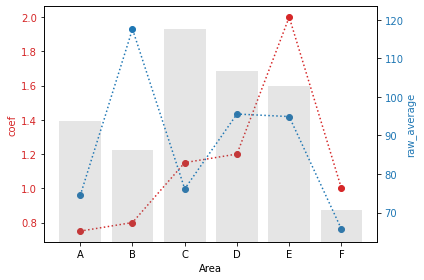

In [79]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Area")
ax1.set_ylabel('coef', color=color)
ax1.scatter(plot_df.Area,plot_df.coef, color = color)
ax1.plot(plot_df.Area,plot_df.coef, color = color, linestyle = ":")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

ax2.set_ylim(min_on_scale * 0.95, max_on_scale * 1.05)

color = 'tab:blue'
ax2.set_ylabel('raw_average', color=color)
ax2.scatter(plot_df.Area,plot_df.raw_average, color = color)
ax2.plot(plot_df.Area,plot_df.raw_average, color = color, linestyle = ":")
ax2.tick_params(axis='y', labelcolor=color)

ax2.bar(plot_df.Area,plot_df.exposure, color = "grey", alpha = 0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()